# Initialization

> We need to make sure that our gradients do not explode or vanish. This should help us break down the apropriate initialization for each torch module.

In [1]:
# |default_exp init

In [2]:
# |export
from collections import Counter
from contextlib import contextmanager
from functools import singledispatch

import lightning as L
import matplotlib.pyplot as plt
import torch
from torch import nn

from slow_diffusion.fashionmnist import FashionMNISTDataModule
from slow_diffusion.model import ConvBlock
from slow_diffusion.training import get_tiny_unet_lightning

/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# |hide
plt.style.use("ggplot")

In [4]:
dm = FashionMNISTDataModule(bs=32)
dm.setup()

In [5]:
((x_t, t), ε) = next(iter(dm.train_dataloader()))
x_t.shape

torch.Size([32, 1, 32, 32])

Let's verify that the distribution remains normal after the transformation is applied.

In [6]:
@singledispatch
def kaiming(module):
    ...

In [7]:
@kaiming.register(ConvBlock)
def _(c):
    if isinstance(c.act, nn.ReLU):
        torch.nn.init.kaiming_normal_(c.conv.weight, a=0.0)
    elif isinstance(c.act, nn.SiLU):
        torch.nn.init.kaiming_normal_(c.conv.weight, a=0.1)
    else:
        raise ValueError
    if c.conv.bias is not None:
        torch.nn.init.constant_(c.conv.bias, 0)

In [8]:
conv_relu_default = ConvBlock(1, 1, act=nn.ReLU)
conv_relu = ConvBlock(1, 1, act=nn.ReLU)
conv_silu_default = ConvBlock(1, 1, act=nn.SiLU)
conv_silu = ConvBlock(1, 1, act=nn.SiLU)
for m in [conv_relu, conv_silu]:
    kaiming(m)

In [9]:
def plot(xb, args, modules: list[tuple[str, nn.Module]]):
    fig, axes = plt.subplots(1, len(modules), figsize=(4 * len(modules), 4))
    for ax, (label, c) in zip(axes, cs):
        _, bins, _ = ax.hist(xb.reshape(-1), bins=30, alpha=0.5, label="input")
        with torch.no_grad():
            yb = c(*args)
        ax.hist(yb.reshape(-1), bins, alpha=0.33, label=label)
        ax.set(xlabel="Logit magnitude", ylabel="Frequency", title=label)
    fig.tight_layout()

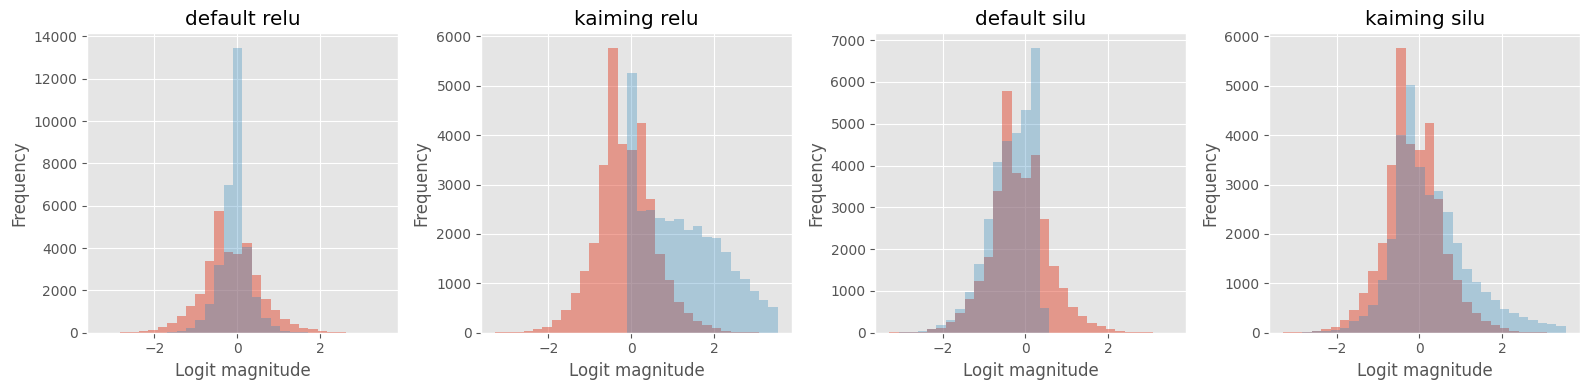

In [10]:
cs = [
    ("default relu", conv_relu_default),
    ("kaiming relu", conv_relu),
    ("default silu", conv_silu_default),
    ("kaiming silu", conv_silu),
]
plot(x_t, (x_t,), cs)

In [11]:
# |hide
for c in cs:
    del c

Good! The Kaiming methods preserve the distribution variance, unlike the default.

Let's start with initializing with Kaiming SiLU and see how we might need to adjust the ResBlocks.

In [12]:
def append(module, _, acts):
    module.acts = acts

In [13]:
@contextmanager
def monitor_activations(model):
    hooks = []
    for name, m in model.unet.named_modules():
        hooks.append(m.register_forward_hook(append))
    yield
    for hook in hooks:
        hook.remove()

In [14]:
un = get_tiny_unet_lightning(act=nn.SiLU)
un = un.apply(kaiming)

with monitor_activations(un), torch.no_grad():
    un.step(((x_t, t), ε))

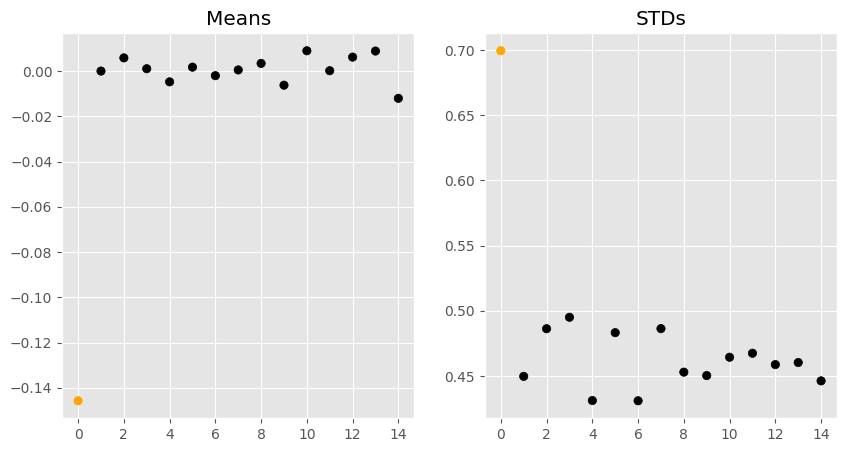

In [15]:
def plot_per_layer_stats(mods):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.set(title="Means")
    ax1.set(title="STDs")

    data = []
    data.append((x_t.mean(), x_t.std(), "Input"))
    for m in mods:
        clsname = m.__class__.__name__
        row = (m.acts.mean(), m.acts.std(), clsname)
        data.append(row)
    means, stds, clss = zip(*data)
    idxs = torch.arange(0, len(data))
    color_map = {
        "Downblock": "b",
        "Upblock": "r",
        "Conv2d": "g",
        "ConvBlock": "purple",
        "Input": "orange",
        "ResBlock": "black",
    }
    colors = [color_map[c] for c in clss]
    ax0.scatter(idxs, means, c=colors)
    ax1.scatter(idxs, stds, c=colors)


def plot_per_resnet_stats(model):
    resnets = []
    for block in [*model.unet.downblocks, *model.unet.upblocks]:
        for conv in block.convs:
            resnets.append(conv)
    plot_per_layer_stats(resnets)


plot_per_resnet_stats(un)

Nothing suspicious after one iteration. Let's train it and see what happens.

In [18]:
def plot_per_layer_stats_after_training(model):
    trainer = L.Trainer(max_epochs=1, precision="bf16-mixed", max_steps=100)
    trainer.fit(model=model, datamodule=dm)
    with monitor_activations(model), torch.no_grad():
        model.step(((x_t, t), ε))
    resnets = []
    for block in [*model.unet.downblocks, *model.unet.upblocks]:
        for conv in block.convs:
            resnets.append(conv)
    plot_per_layer_stats(resnets)

Here's a much clearer illustration of what's going on.

In [19]:
model = get_tiny_unet_lightning(act=nn.ReLU)
model = model.apply(kaiming)
plot_per_layer_stats_after_training(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | unet    | Unet    | 185 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
185 M     Trainable params
0         Non-trainable params
185 M     Total params
742.125   Total estimated model params size (MB)


Epoch 0:   0%|             | 3/1875 [03:00<31:13:33,  0.02it/s, v_num=58]

RuntimeError: Placeholder storage has not been allocated on MPS device!

**After training,** the means remain around 0, but the standard deviation significantly increases throughout the network.

Now, check this out:

In [ ]:
model = get_tiny_unet_lightning()  # no initialization
plot_per_layer_stats_after_training(model)

Much more even. So, it looks like [default initialization is fine](https://forums.fast.ai/t/lesson-24-official-topic/104358/12).

In [20]:
# | hide
import nbdev

nbdev.nbdev_export()